In [1]:
! pip install gdown

In [2]:
!gdown --id #removi o id não sei se o conjunto pode ser publico 

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1iozLjDgtNmX992k0-YXX5xUIfMJfqjNx
From (redirected): https://drive.google.com/uc?id=1iozLjDgtNmX992k0-YXX5xUIfMJfqjNx&confirm=t&uuid=ed21d05f-2eb5-4012-a4e7-2670a1839ba7
To: /kaggle/working/Treinamento.zip
100%|███████████████████████████████████████| 3.55G/3.55G [00:33<00:00, 104MB/s]


In [3]:
import zipfile
import os

def descompactar_zip(caminho_arquivo, caminho_destino):
    with zipfile.ZipFile(caminho_arquivo, 'r') as zip_ref:
        zip_ref.extractall(caminho_destino)

In [4]:
!gdown --id #removi o id não sei se o conjunto pode ser publico 
descompactar_zip("/kaggle/working/Teste.zip", "/kaggle/working/imagens")

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1MbDIEOICj5Uxx2PXem8_J3unotMMv49C
From (redirected): https://drive.google.com/uc?id=1MbDIEOICj5Uxx2PXem8_J3unotMMv49C&confirm=t&uuid=ae9a426f-e640-41e0-af34-997104c0a587
To: /kaggle/working/Teste.zip
100%|████████████████████████████████████████| 444M/444M [00:04<00:00, 99.2MB/s]


In [5]:
import random
import shutil
caminho_arquivo = '/kaggle/working/Treinamento.zip'
caminho_destino = '/kaggle/working/imagens'
descompactar_zip(caminho_arquivo, caminho_destino)


def dividir_dados(pasta_origem, pasta_destino_treino, pasta_destino_validacao, proporcao_treino=0.8):
  """
  Divide aleatoriamente os dados em conjuntos de treino e validação.

  Args:
    pasta_origem: Caminho da pasta com os dados originais.
    pasta_destino_treino: Caminho da pasta onde os dados de treino serão copiados.
    pasta_destino_validacao: Caminho da pasta onde os dados de validação serão copiados.
    proporcao_treino: Proporção dos dados que serão usados para treino (padrão: 0.8).
  """

  for subpasta in os.listdir(pasta_origem):
    caminho_subpasta = os.path.join(pasta_origem, subpasta)
    if os.path.isdir(caminho_subpasta):
      caminho_treino_subpasta = os.path.join(pasta_destino_treino, subpasta)
      caminho_validacao_subpasta = os.path.join(pasta_destino_validacao, subpasta)
      os.makedirs(caminho_treino_subpasta, exist_ok=True)
      os.makedirs(caminho_validacao_subpasta, exist_ok=True)

      arquivos = [f for f in os.listdir(caminho_subpasta) if os.path.isfile(os.path.join(caminho_subpasta, f))]
      random.shuffle(arquivos)
      num_treino = int(len(arquivos) * proporcao_treino)

      for i, arquivo in enumerate(arquivos):
        caminho_arquivo_origem = os.path.join(caminho_subpasta, arquivo)
        if i < num_treino:
          caminho_arquivo_destino = os.path.join(caminho_treino_subpasta, arquivo)
        else:
          caminho_arquivo_destino = os.path.join(caminho_validacao_subpasta, arquivo)
        shutil.copy(caminho_arquivo_origem, caminho_arquivo_destino)

# Exemplo de uso:
pasta_origem = '/kaggle/working/imagens/Treinamento'
pasta_destino_treino = '/kaggle/working/imagens/treino'
pasta_destino_validacao = '/kaggle/working/imagens/validacao'

dividir_dados(pasta_origem, pasta_destino_treino, pasta_destino_validacao)

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Inicialize os geradores de dados
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normaliza os valores de pixel para o intervalo [0, 1]
    rotation_range=30,  # Rotaciona as imagens aleatoriamente
    width_shift_range=0.2,  # Move as imagens horizontalmente
    height_shift_range=0.2,  # Move as imagens verticalmente
    shear_range=0.2,  # Aplica uma transformação de cisalhamento
    zoom_range=0.2,  # Aplica zoom nas imagens
    horizontal_flip=True,  # Inverte as imagens horizontalmente
    fill_mode='nearest'  # Preenche pixels ausentes
)

validation_datagen = ImageDataGenerator(rescale=1./255)  # Apenas normalização para o conjunto de validação

# Diretórios de dados
train_dir = '/kaggle/working/imagens/treino'
test_dir = '/kaggle/working/imagens/Teste'
val_dir = '/kaggle/working/imagens/validacao'

# Geradores de dados
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(228, 228),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(228, 228),
    batch_size=32,
    class_mode='categorical'
)

test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(228, 228),
    batch_size=1,
    class_mode='categorical'
)


Found 15697 images belonging to 2 classes.
Found 3925 images belonging to 2 classes.
Found 2465 images belonging to 2 classes.


In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(228, 228, 3))

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(
    train_generator,
    epochs=25,                  # Ajuste conforme necessário
    validation_data=validation_generator
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730423552.945842     123 service.cc:145] XLA service 0x7d1174003760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730423552.945918     123 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1730423583.864439     123 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_25', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1730423583.919181     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the

491/491 ━━━━━━━━━━━━━━━━━━━━ 366s 576ms/step - accuracy: 0.8145 - loss: 0.8202 - val_accuracy: 0.8354 - val_loss: 1.7619
Epoch 2/25
491/491 ━━━━━━━━━━━━━━━━━━━━ 258s 518ms/step - accuracy: 0.8759 - loss: 0.3311 - val_accuracy: 0.8543 - val_loss: 0.3634
Epoch 3/25
491/491 ━━━━━━━━━━━━━━━━━━━━ 257s 515ms/step - accuracy: 0.8796 - loss: 0.3040 - val_accuracy: 0.8882 - val_loss: 0.4196
Epoch 4/25
491/491 ━━━━━━━━━━━━━━━━━━━━ 249s 501ms/step - accuracy: 0.8871 - loss: 0.2928 - val_accuracy: 0.8930 - val_loss: 0.3167
Epoch 5/25
491/491 ━━━━━━━━━━━━━━━━━━━━ 249s 500ms/step - accuracy: 0.8958 - loss: 0.2691 - val_accuracy: 0.8910 - val_loss: 0.8058
Epoch 6/25
491/491 ━━━━━━━━━━━━━━━━━━━━ 248s 498ms/step - accuracy: 0.8961 - loss: 0.2764 - val_accuracy: 0.8994 - val_loss: 0.2933
Epoch 7/25
491/491 ━━━━━━━━━━━━━━━━━━━━ 245s 493ms/step - accuracy: 0.9023 - loss: 0.2604 - val_accuracy: 0.9001 - val_loss: 0.2912
Epoch 8/25
491/491 ━━━━━━━━━━━━━━━━━━━━ 247s 496ms/step - accuracy: 0.9093 - loss: 0.23

In [ ]:
# Salva o modelo em um arquivo .h5
model.save('modelo_treinado.h5')


2465/2465 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step


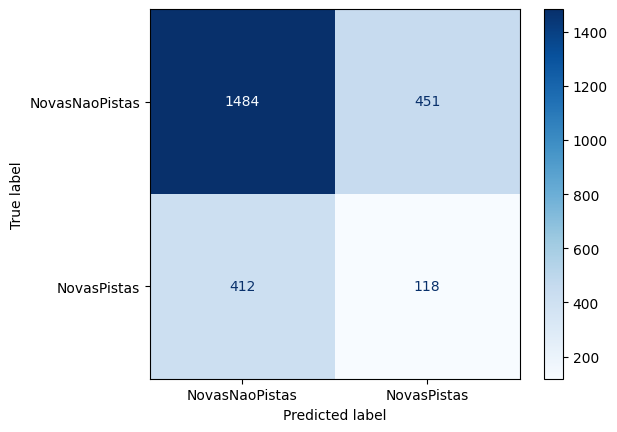

In [14]:
# Fazer previsões no conjunto de validação
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Obter rótulos verdadeiros
y_true = test_generator.classes

# Gerar matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Exibir a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.show()

2465/2465 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step


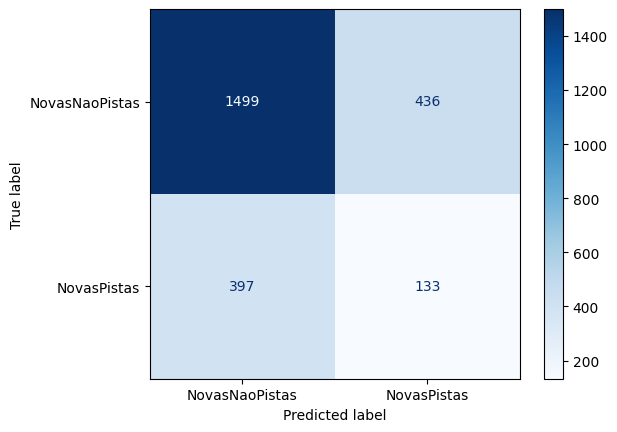

                precision    recall  f1-score   support

NovasNaoPistas       0.79      0.77      0.78      1935
   NovasPistas       0.23      0.25      0.24       530

      accuracy                           0.66      2465
     macro avg       0.51      0.51      0.51      2465
  weighted avg       0.67      0.66      0.67      2465



In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Fazer previsões no conjunto de validação
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Obter rótulos verdadeiros
y_true = test_generator.classes

# Gerar e exibir a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Gerar e exibir o relatório de classificação com precisão, recall e F1-score
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)
